In [1]:
%load_ext autoreload
%autoreload 2 


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from aux_functions import put_gaze_annotation, rgb,angle_to_2d,is_accurate


# Configuraciones

Configuraciones para CUDA

In [3]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cuda


# Analisis de datos

In [5]:
from datasets import MPIIFaceGaze

In [6]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=10)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 150 imagenes


In [7]:
ds[20]

(array([[[ 25,  27,  24],
         [ 30,  31,  26],
         [ 35,  37,  30],
         ...,
         [  7,  17,  17],
         [ 10,  17,  11],
         [ 10,  16,  10]],
 
        [[ 23,  26,  23],
         [ 28,  33,  29],
         [ 34,  42,  36],
         ...,
         [  9,  18,  16],
         [  8,  17,  14],
         [  7,  17,  13]],
 
        [[ 21,  25,  23],
         [ 26,  35,  32],
         [ 33,  45,  41],
         ...,
         [ 11,  19,  16],
         [  6,  18,  17],
         [  6,  17,  16]],
 
        ...,
 
        [[112,  42,   4],
         [115,  46,   7],
         [116,  50,   9],
         ...,
         [  9,   3,   0],
         [  8,   3,   0],
         [  7,   3,   0]],
 
        [[113,  43,   4],
         [114,  46,   6],
         [113,  49,   7],
         ...,
         [  9,   3,   0],
         [  8,   2,   0],
         [  7,   2,   0]],
 
        [[112,  44,   4],
         [112,  46,   5],
         [109,  48,   5],
         ...,
         [  9,   2,   0],
  

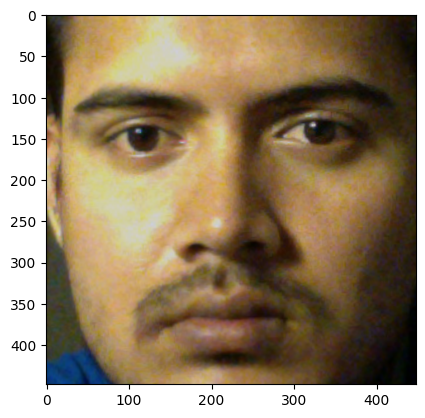

In [8]:
plt.imshow(ds.images_list[20][:,:,::-1])

#### Creación de los set de entrenamiento y testeo

- Al usar resnet18 como capas previas (para aprovechar y hacer transfer learning), las imagenes deben ser redimensionadas a 224x224
- Data augmentation:
    - EXPLICAR

In [ ]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
])


In [ ]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=100)
print(f"Se cargaron {len(ds)} imagenes")

In [ ]:
# Separo en entrenamiento y validacion
train_size = int(0.8*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


torch.Size([16, 3, 224, 224]) torch.Size([16, 2])
pitch yaw: tensor([-0.2167,  0.1762], dtype=torch.float64)


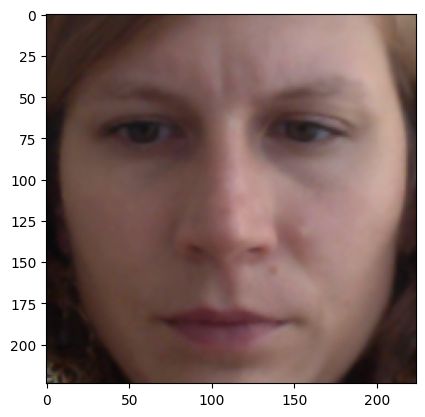

In [ ]:
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Grafico una imagen con el label para asegurarnos que este bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

# Entrenamiento

#### Instanciación del modelo y prueba de dimensiones

In [9]:
from models import GazeEstimation_ResNet18
from torchsummary import summary

In [10]:
# Instanciación del model
model = GazeEstimation_ResNet18(pretrained=True)

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tensor([[-0.1983,  0.2879],
        [-0.0090,  0.2306],
        [-0.1028,  0.1486],
        [-0.0424,  0.3413],
        [ 0.1711,  0.0779],
        [ 0.0779,  0.2496],
        [ 0.0129,  0.3190],
        [-0.0779,  0.1902]], grad_fn=<AddmmBackward0>)


In [11]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Entrenamiento propiamente dicho

In [21]:
model.fit(train_loader, val_loader, criterion, optimizer, epochs=100, device=device, save_model='gaze_estimation_resnet18.pth')

Epoch 1/100


  0%|          | 0/15 [00:00<?, ?it/s]

Validation loss 0.01409: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Training Loss / Accuracy: 0.0017 / 70.42% | Validation Loss / Accuracy: 0.0141 / 21.88%
Epoch 2/100


Validation loss 0.01403: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Training Loss / Accuracy: 0.0017 / 67.92% | Validation Loss / Accuracy: 0.0140 / 22.40%
Epoch 3/100


Validation loss 0.01404: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Training Loss / Accuracy: 0.0016 / 75.00% | Validation Loss / Accuracy: 0.0140 / 27.08%
Epoch 4/100


Validation loss 0.01403: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Training Loss / Accuracy: 0.0017 / 70.83% | Validation Loss / Accuracy: 0.0140 / 25.52%
Epoch 5/100


Validation loss 0.01448: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Training Loss / Accuracy: 0.0018 / 68.75% | Validation Loss / Accuracy: 0.0145 / 32.29%
Epoch 6/100


Validation loss 0.01446: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Training Loss / Accuracy: 0.0014 / 74.17% | Validation Loss / Accuracy: 0.0145 / 29.69%
Epoch 7/100


Validation loss 0.01570: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Training Loss / Accuracy: 0.0021 / 65.00% | Validation Loss / Accuracy: 0.0157 / 16.15%
Epoch 8/100


Validation loss 0.01525: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Training Loss / Accuracy: 0.0023 / 62.08% | Validation Loss / Accuracy: 0.0153 / 32.29%
Epoch 9/100


Validation loss 0.01339: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0026 / 63.33% | Validation Loss / Accuracy: 0.0134 / 27.60%
Epoch 10/100


Validation loss 0.01531: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Training Loss / Accuracy: 0.0018 / 74.58% | Validation Loss / Accuracy: 0.0153 / 17.19%
Epoch 11/100


Validation loss 0.01416: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Training Loss / Accuracy: 0.0016 / 69.17% | Validation Loss / Accuracy: 0.0142 / 24.48%
Epoch 12/100


Validation loss 0.01368: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Training Loss / Accuracy: 0.0020 / 62.92% | Validation Loss / Accuracy: 0.0137 / 29.69%
Epoch 13/100


Validation loss 0.01235: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Training Loss / Accuracy: 0.0016 / 68.75% | Validation Loss / Accuracy: 0.0123 / 39.06%
Epoch 14/100


Validation loss 0.01539: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Training Loss / Accuracy: 0.0018 / 67.92% | Validation Loss / Accuracy: 0.0154 / 18.75%
Epoch 15/100


Validation loss 0.01399: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Training Loss / Accuracy: 0.0017 / 70.83% | Validation Loss / Accuracy: 0.0140 / 32.29%
Epoch 16/100


Validation loss 0.01316: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0012 / 76.25% | Validation Loss / Accuracy: 0.0132 / 35.94%
Epoch 17/100


Validation loss 0.01420: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Training Loss / Accuracy: 0.0022 / 63.33% | Validation Loss / Accuracy: 0.0142 / 25.00%
Epoch 18/100


Validation loss 0.01307: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Training Loss / Accuracy: 0.0019 / 71.25% | Validation Loss / Accuracy: 0.0131 / 30.21%
Epoch 19/100


Validation loss 0.01365: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Training Loss / Accuracy: 0.0018 / 59.58% | Validation Loss / Accuracy: 0.0137 / 28.12%
Epoch 20/100


Validation loss 0.01491: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Training Loss / Accuracy: 0.0014 / 75.83% | Validation Loss / Accuracy: 0.0149 / 24.48%
Epoch 21/100


Validation loss 0.01403: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Training Loss / Accuracy: 0.0011 / 79.58% | Validation Loss / Accuracy: 0.0140 / 26.56%
Epoch 22/100


Validation loss 0.01345: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0010 / 80.83% | Validation Loss / Accuracy: 0.0134 / 29.69%
Epoch 23/100


Validation loss 0.01263: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Training Loss / Accuracy: 0.0015 / 70.83% | Validation Loss / Accuracy: 0.0126 / 22.92%
Epoch 24/100


Validation loss 0.01380: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Training Loss / Accuracy: 0.0012 / 71.25% | Validation Loss / Accuracy: 0.0138 / 24.48%
Epoch 25/100


Validation loss 0.01427: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Training Loss / Accuracy: 0.0017 / 63.33% | Validation Loss / Accuracy: 0.0143 / 26.04%
Epoch 26/100


Validation loss 0.01287: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Training Loss / Accuracy: 0.0014 / 72.08% | Validation Loss / Accuracy: 0.0129 / 27.08%
Epoch 27/100


Validation loss 0.01355: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Training Loss / Accuracy: 0.0012 / 77.50% | Validation Loss / Accuracy: 0.0135 / 24.48%
Epoch 28/100


Validation loss 0.01262: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Training Loss / Accuracy: 0.0013 / 75.00% | Validation Loss / Accuracy: 0.0126 / 33.33%
Epoch 29/100


Validation loss 0.01344: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0012 / 78.33% | Validation Loss / Accuracy: 0.0134 / 28.65%
Epoch 30/100


Validation loss 0.01290: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Training Loss / Accuracy: 0.0013 / 72.50% | Validation Loss / Accuracy: 0.0129 / 25.52%
Epoch 31/100


Validation loss 0.01260: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Training Loss / Accuracy: 0.0010 / 80.00% | Validation Loss / Accuracy: 0.0126 / 22.40%
Epoch 32/100


Validation loss 0.01226: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Training Loss / Accuracy: 0.0010 / 77.92% | Validation Loss / Accuracy: 0.0123 / 23.96%
Epoch 33/100


Validation loss 0.01288: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Training Loss / Accuracy: 0.0012 / 76.25% | Validation Loss / Accuracy: 0.0129 / 32.29%
Epoch 34/100


Validation loss 0.01387: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0011 / 80.42% | Validation Loss / Accuracy: 0.0139 / 31.77%
Epoch 35/100


Validation loss 0.01335: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Training Loss / Accuracy: 0.0012 / 75.83% | Validation Loss / Accuracy: 0.0133 / 29.17%
Epoch 36/100


Validation loss 0.01412: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Training Loss / Accuracy: 0.0012 / 77.50% | Validation Loss / Accuracy: 0.0141 / 30.73%
Epoch 37/100


Validation loss 0.01314: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Training Loss / Accuracy: 0.0009 / 83.33% | Validation Loss / Accuracy: 0.0131 / 34.38%
Epoch 38/100


Validation loss 0.01363: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Training Loss / Accuracy: 0.0009 / 83.33% | Validation Loss / Accuracy: 0.0136 / 31.77%
Epoch 39/100


Validation loss 0.01418: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Training Loss / Accuracy: 0.0009 / 80.42% | Validation Loss / Accuracy: 0.0142 / 21.35%
Epoch 40/100


Validation loss 0.01302: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Training Loss / Accuracy: 0.0009 / 80.83% | Validation Loss / Accuracy: 0.0130 / 26.56%
Epoch 41/100


Validation loss 0.01361: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Training Loss / Accuracy: 0.0009 / 78.33% | Validation Loss / Accuracy: 0.0136 / 30.21%
Epoch 42/100


Validation loss 0.01284: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Training Loss / Accuracy: 0.0010 / 81.67% | Validation Loss / Accuracy: 0.0128 / 25.52%
Epoch 43/100


Validation loss 0.01296: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Training Loss / Accuracy: 0.0010 / 77.50% | Validation Loss / Accuracy: 0.0130 / 21.35%
Epoch 44/100


Validation loss 0.01387: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Training Loss / Accuracy: 0.0007 / 84.17% | Validation Loss / Accuracy: 0.0139 / 24.48%
Epoch 45/100


Validation loss 0.01187: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Training Loss / Accuracy: 0.0007 / 81.25% | Validation Loss / Accuracy: 0.0119 / 33.33%
Epoch 46/100


Validation loss 0.01225: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Training Loss / Accuracy: 0.0006 / 85.00% | Validation Loss / Accuracy: 0.0123 / 31.25%
Epoch 47/100


Validation loss 0.01205: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Training Loss / Accuracy: 0.0007 / 83.75% | Validation Loss / Accuracy: 0.0121 / 28.65%
Epoch 48/100


Validation loss 0.01295: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Training Loss / Accuracy: 0.0007 / 83.33% | Validation Loss / Accuracy: 0.0130 / 26.56%
Epoch 49/100


Validation loss 0.01303: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Training Loss / Accuracy: 0.0006 / 87.08% | Validation Loss / Accuracy: 0.0130 / 26.04%
Epoch 50/100


Validation loss 0.01228: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Training Loss / Accuracy: 0.0006 / 89.17% | Validation Loss / Accuracy: 0.0123 / 32.29%
Epoch 51/100


Validation loss 0.01340: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Training Loss / Accuracy: 0.0006 / 86.25% | Validation Loss / Accuracy: 0.0134 / 32.81%
Epoch 52/100


Validation loss 0.01272: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Training Loss / Accuracy: 0.0006 / 90.83% | Validation Loss / Accuracy: 0.0127 / 24.48%
Epoch 53/100


Validation loss 0.01305: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Training Loss / Accuracy: 0.0007 / 85.42% | Validation Loss / Accuracy: 0.0130 / 29.17%
Epoch 54/100


Validation loss 0.01150: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Training Loss / Accuracy: 0.0005 / 88.33% | Validation Loss / Accuracy: 0.0115 / 24.48%
Epoch 55/100


Validation loss 0.01253: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Training Loss / Accuracy: 0.0006 / 85.83% | Validation Loss / Accuracy: 0.0125 / 21.88%
Epoch 56/100


Validation loss 0.01189: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Training Loss / Accuracy: 0.0005 / 86.67% | Validation Loss / Accuracy: 0.0119 / 29.69%
Epoch 57/100


Validation loss 0.01183: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Training Loss / Accuracy: 0.0005 / 87.50% | Validation Loss / Accuracy: 0.0118 / 26.56%
Epoch 58/100


Validation loss 0.01234: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Training Loss / Accuracy: 0.0007 / 84.58% | Validation Loss / Accuracy: 0.0123 / 27.08%
Epoch 59/100


Validation loss 0.01217: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Training Loss / Accuracy: 0.0007 / 87.08% | Validation Loss / Accuracy: 0.0122 / 19.27%
Epoch 60/100


Validation loss 0.01207: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Training Loss / Accuracy: 0.0004 / 91.25% | Validation Loss / Accuracy: 0.0121 / 26.04%
Epoch 61/100


Validation loss 0.01218: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Training Loss / Accuracy: 0.0005 / 89.17% | Validation Loss / Accuracy: 0.0122 / 19.27%
Epoch 62/100


Validation loss 0.01387: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Training Loss / Accuracy: 0.0005 / 87.08% | Validation Loss / Accuracy: 0.0139 / 21.35%
Epoch 63/100


Validation loss 0.01221: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Training Loss / Accuracy: 0.0005 / 92.50% | Validation Loss / Accuracy: 0.0122 / 18.75%
Epoch 64/100


Validation loss 0.01173: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Training Loss / Accuracy: 0.0006 / 89.58% | Validation Loss / Accuracy: 0.0117 / 28.12%
Epoch 65/100


Validation loss 0.01101: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Training Loss / Accuracy: 0.0005 / 89.58% | Validation Loss / Accuracy: 0.0110 / 23.44%
Epoch 66/100


Validation loss 0.01180: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Training Loss / Accuracy: 0.0005 / 88.33% | Validation Loss / Accuracy: 0.0118 / 29.69%
Epoch 67/100


Validation loss 0.01255: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Training Loss / Accuracy: 0.0006 / 89.58% | Validation Loss / Accuracy: 0.0126 / 28.12%
Epoch 68/100


Validation loss 0.01201: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Training Loss / Accuracy: 0.0004 / 92.50% | Validation Loss / Accuracy: 0.0120 / 34.38%
Epoch 69/100


Validation loss 0.01243: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Training Loss / Accuracy: 0.0004 / 87.08% | Validation Loss / Accuracy: 0.0124 / 26.56%
Epoch 70/100


Validation loss 0.01174: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Training Loss / Accuracy: 0.0005 / 88.75% | Validation Loss / Accuracy: 0.0117 / 27.60%
Epoch 71/100


Validation loss 0.01181: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Training Loss / Accuracy: 0.0004 / 92.92% | Validation Loss / Accuracy: 0.0118 / 29.17%
Epoch 72/100


Validation loss 0.01250: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Training Loss / Accuracy: 0.0004 / 85.42% | Validation Loss / Accuracy: 0.0125 / 27.60%
Epoch 73/100


Validation loss 0.01253: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Training Loss / Accuracy: 0.0003 / 92.50% | Validation Loss / Accuracy: 0.0125 / 20.83%
Epoch 74/100


Validation loss 0.01137: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Training Loss / Accuracy: 0.0003 / 93.75% | Validation Loss / Accuracy: 0.0114 / 22.92%
Epoch 75/100


Validation loss 0.01157: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Training Loss / Accuracy: 0.0003 / 94.58% | Validation Loss / Accuracy: 0.0116 / 26.56%
Epoch 76/100


Validation loss 0.01170: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Training Loss / Accuracy: 0.0003 / 92.08% | Validation Loss / Accuracy: 0.0117 / 30.73%
Epoch 77/100


Validation loss 0.01210: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Training Loss / Accuracy: 0.0003 / 96.67% | Validation Loss / Accuracy: 0.0121 / 27.60%
Epoch 78/100


Validation loss 0.01222: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Training Loss / Accuracy: 0.0005 / 89.58% | Validation Loss / Accuracy: 0.0122 / 31.25%
Epoch 79/100


Validation loss 0.01232: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Training Loss / Accuracy: 0.0004 / 92.50% | Validation Loss / Accuracy: 0.0123 / 32.81%
Epoch 80/100


Validation loss 0.01259: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Training Loss / Accuracy: 0.0005 / 89.17% | Validation Loss / Accuracy: 0.0126 / 35.42%
Epoch 81/100


Validation loss 0.01457: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Training Loss / Accuracy: 0.0005 / 92.92% | Validation Loss / Accuracy: 0.0146 / 20.31%
Epoch 82/100


Validation loss 0.01254: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Training Loss / Accuracy: 0.0004 / 90.00% | Validation Loss / Accuracy: 0.0125 / 32.29%
Epoch 83/100


Validation loss 0.01263: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Training Loss / Accuracy: 0.0004 / 90.00% | Validation Loss / Accuracy: 0.0126 / 29.69%
Epoch 84/100


Validation loss 0.01250: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Training Loss / Accuracy: 0.0004 / 91.25% | Validation Loss / Accuracy: 0.0125 / 32.29%
Epoch 85/100


Validation loss 0.01231: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Training Loss / Accuracy: 0.0003 / 95.42% | Validation Loss / Accuracy: 0.0123 / 25.00%
Epoch 86/100


Validation loss 0.01223: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Training Loss / Accuracy: 0.0003 / 94.58% | Validation Loss / Accuracy: 0.0122 / 36.46%
Epoch 87/100


Validation loss 0.01233: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Training Loss / Accuracy: 0.0003 / 92.92% | Validation Loss / Accuracy: 0.0123 / 26.56%
Epoch 88/100


Validation loss 0.01199: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Training Loss / Accuracy: 0.0004 / 89.17% | Validation Loss / Accuracy: 0.0120 / 31.25%
Epoch 89/100


Validation loss 0.01213: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Training Loss / Accuracy: 0.0003 / 90.83% | Validation Loss / Accuracy: 0.0121 / 28.65%
Epoch 90/100


Validation loss 0.01260: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Training Loss / Accuracy: 0.0003 / 93.33% | Validation Loss / Accuracy: 0.0126 / 30.73%
Epoch 91/100


Validation loss 0.01239: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Training Loss / Accuracy: 0.0003 / 92.50% | Validation Loss / Accuracy: 0.0124 / 28.65%
Epoch 92/100


Validation loss 0.01314: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Training Loss / Accuracy: 0.0003 / 92.08% | Validation Loss / Accuracy: 0.0131 / 27.08%
Epoch 93/100


Validation loss 0.01238: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Training Loss / Accuracy: 0.0002 / 92.50% | Validation Loss / Accuracy: 0.0124 / 32.29%
Epoch 94/100


Validation loss 0.01186: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Training Loss / Accuracy: 0.0002 / 95.83% | Validation Loss / Accuracy: 0.0119 / 27.60%
Epoch 95/100


Validation loss 0.01258: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Training Loss / Accuracy: 0.0002 / 93.33% | Validation Loss / Accuracy: 0.0126 / 28.12%
Epoch 96/100


Validation loss 0.01253: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Training Loss / Accuracy: 0.0003 / 93.75% | Validation Loss / Accuracy: 0.0125 / 34.38%
Epoch 97/100


Validation loss 0.01131: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Training Loss / Accuracy: 0.0002 / 92.92% | Validation Loss / Accuracy: 0.0113 / 28.12%
Epoch 98/100


Validation loss 0.01269: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Training Loss / Accuracy: 0.0003 / 95.00% | Validation Loss / Accuracy: 0.0127 / 29.17%
Epoch 99/100


Validation loss 0.01197: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Training Loss / Accuracy: 0.0003 / 95.42% | Validation Loss / Accuracy: 0.0120 / 27.60%
Epoch 100/100


Validation loss 0.01231: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

Training Loss / Accuracy: 0.0003 / 95.42% | Validation Loss / Accuracy: 0.0123 / 32.81%


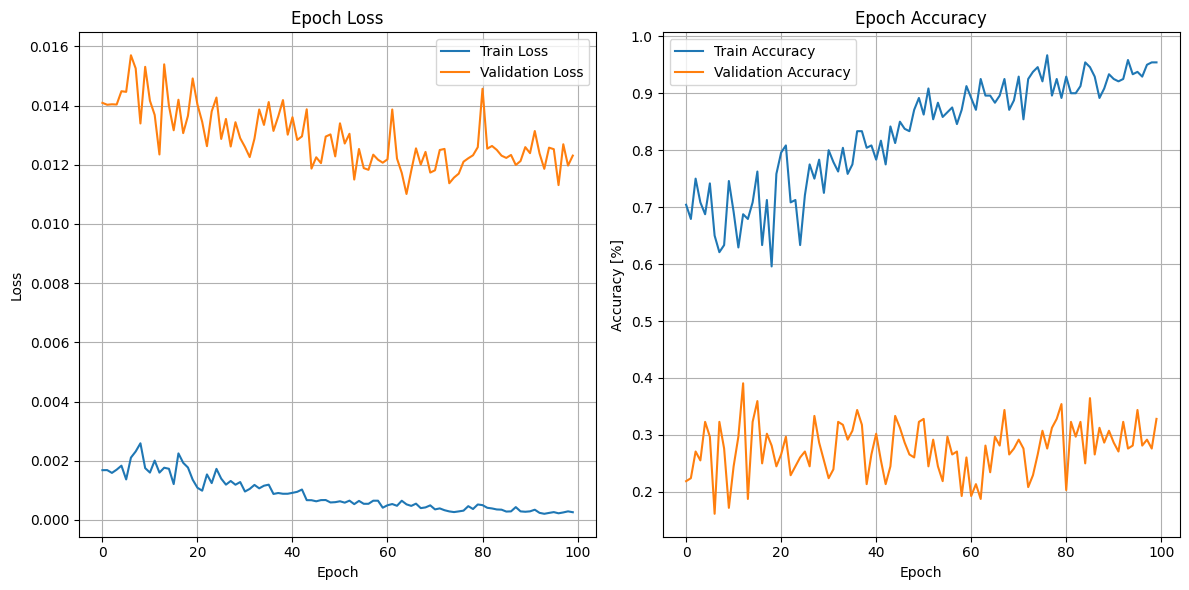

In [23]:
# Grafico las curvas de entrenamiento y validacion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Loss subplot
ax1.set_title("Epoch Loss")
ax1.plot(range(len(model.epoch_train_loss)), model.epoch_train_loss, label='Train Loss')
ax1.plot(range(len(model.epoch_val_loss)), model.epoch_val_loss, label='Validation Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()  

# Accuracy subplot
ax2.set_title("Epoch Accuracy")
ax2.plot(range(len(model.epoch_train_accuracy)), model.epoch_train_accuracy, label='Train Accuracy')
ax2.plot(range(len(model.epoch_val_accuracy)), model.epoch_val_accuracy, label='Validation Accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy [%]")
ax2.grid(True)
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [48]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet18()
new_model.load_state_dict(torch.load('gaze_estimation_resnet18.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device)  # Batch of 8 images, 3 channels (RGB), 224x224 resolution
outputs = new_model(inputs)  # Outputs will be the predicted yaw and pitch angles

print(outputs)

tensor([[-0.0640, -0.0612],
        [-0.1143, -0.0353],
        [-0.2594, -0.0823],
        [-0.0428,  0.1168],
        [-0.1383, -0.1369],
        [-0.1333,  0.0982],
        [-0.1410,  0.0388],
        [-0.1661,  0.0684]], device='cuda:0', grad_fn=<AddmmBackward0>)


/tmp/ipykernel_820991/770561724.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('gaze_estimation_resnet18.pth'))


## Validación

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Actual: 
	 pitch,yaw: -0.30140963196754456 0.16914011538028717
	 proyección 2D del ángulo: 240.09° deg
Predicted: 
	 pitch,yaw  -0.11812200397253036 0.051167670637369156
	 proyección 2D del ángulo: 246.51° deg
**Preciso (tolerancia = 10°): 1


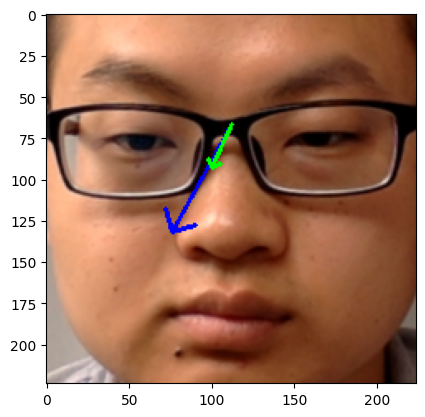

In [51]:

img, gaze = train_dataset[21]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))


predicted_gaze = new_model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()

img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

tolerancia = 10 # 10° de tolerancia para considerar una predicción como error
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

print("Actual: ")
print("\t pitch,yaw:",pitch,yaw)
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print("\t pitch,yaw ",pitch_predicted,yaw_predicted)
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0)) #Actual: flecha azul
img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0)) #Prediced: flecha verde

plt.imshow(rgb(img))







In [20]:
gaze[1]

np.float64(-0.003242463106289506)